In [1]:
import traceback

import numpy as np
import pandas as pd
from IPython.core.display_functions import display
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3 as db

import xml.etree.cElementTree as et
from sklearn import preprocessing

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.debug("test")

sns.set_context('paper')

In [2]:
def process_xml_columns(df_new_cols, cols, match, xml_col):
    path = match[xml_col]
    if path is not None:
        root = et.fromstring(path)
        try:
            temp_column_list = []
            for column in cols:
                row_elements = root.findall('.//{}'.format(column))
                row_list = []
                for row in row_elements:
                    row_list.append(row.text)
                temp_column_list.append(row_list)
            df = pd.DataFrame(temp_column_list)
            df = df.transpose()
            df.columns = df_new_cols
            df['match_api_id'] = match.match_api_id
            return df
        except Exception as e:
            print(e)


def create_new_df_from_xml(df, xml_column, df_cols, df_new_cols):
    new_df = pd.DataFrame()
    for index, row in df[df[xml_column].notna()].iterrows():
        df = process_xml_columns(df_new_cols, df_cols, row, xml_column)
        new_df = pd.concat([new_df, df], ignore_index=True)
    return new_df


def fill_nan_goals(df, col1, col2):
    df_col1_nan = df.loc[df[col1].isna()]
    df_col2_nan = df.loc[df[col2].isna()]
    for index, row in df_col1_nan.iterrows():
        avg_mean = df.loc[df.home_team == row.home_team][col1].mean()
        if avg_mean == avg_mean:
            df.loc[df.match_api_id == row.match_api_id, col1] = round(avg_mean)
        else:
            df.loc[df.match_api_id == row.match_api_id, col1] = 0
    for index, row in df_col2_nan.iterrows():
        avg_mean = df.loc[df.away_team == row.away_team][col2].mean()
        if avg_mean == avg_mean:
            df.loc[df.match_api_id == row.match_api_id, col2] = round(avg_mean)
        else:
            df.loc[df.match_api_id == row.match_api_id, col1] = 0
    return df


def missin_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df


def get_winner(row):
    if row['result_match'] == 'H':
        m_winner = row['home_team']
    elif row['home_team_goal'] == 'D':
        m_winner = 'Draw'
    else:
        m_winner = row['away_team']
    return m_winner


def get_points(row, team):
    if row['home_team'] == team:
        if row['result_match'] == 'H':
            return 3
        elif row['result_match'] == 'A':
            return 0
        else:
            return 1
    else:
        if row['home_team_goal'] == 'H':
            return 0
        elif row['home_team_goal'] == 'A':
            return 3
        else:
            return 1

In [3]:
conn = db.connect('eu_soccer_database/database.sqlite')
chunk_size = 5000
batch_no = 1
for chunk in pd.read_sql("SELECT m.match_api_id,"
                         " Country.name AS country_name,"
                         " League.name AS league_name,"
                         " season,"
                         " stage,"
                         " m.date,"
                         " HT.team_long_name AS  home_team,"
                         " AT.team_long_name AS away_team,"
                         " home_team_goal,"
                         " away_team_goal,"
                         " m.possession,"
                         " CASE"
                         " WHEN m.home_team_goal > m.away_team_goal THEN 'H'"
                         " WHEN m.home_team_goal < m.away_team_goal THEN 'A'"
                         " WHEN m.home_team_goal = m.away_team_goal THEN 'D'"
                         " END AS result_match,"
                         " m.B365H,"
                         " m.B365D,"
                         " m.B365A,"
                         " m.BWH,"
                         " m.BWD,"
                         " m.BWA,"
                         " m.IWH,"
                         " m.IWD,"
                         " m.IWA,"
                         " m.LBH,"
                         " m.LBD,"
                         " m.LBA,"
                         " m.PSH,"
                         " m.PSD,"
                         " m.PSA,"
                         " m.WHH,"
                         " m.WHD,"
                         " m.WHA"
                         " FROM Match as m"
                         " JOIN Country on Country.id = m.country_id"
                         " JOIN League on League.id = m.league_id"
                         " LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id"
                         " LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id"
                         " LEFT JOIN Player AS H6 on H6.player_api_id = m.home_player_6"
                         " LEFT JOIN Player AS H7 on H7.player_api_id = m.home_player_7"
                         " LEFT JOIN Player AS H8 on H8.player_api_id = m.home_player_8"
                         " LEFT JOIN Player AS H9 on H9.player_api_id = m.home_player_9"
                         " LEFT JOIN Player AS H10 on H10.player_api_id = m.home_player_10"
                         " LEFT JOIN Player AS H11 on H11.player_api_id = m.home_player_11"
                         " LEFT JOIN Player AS A6 on A6.player_api_id = m.away_player_6"
                         " LEFT JOIN Player AS A7 on A7.player_api_id = m.away_player_7"
                         " LEFT JOIN Player AS A8 on A8.player_api_id = m.away_player_8"
                         " LEFT JOIN Player AS A9 on A9.player_api_id = m.away_player_9"
                         " LEFT JOIN Player AS A10 on A10.player_api_id = m.away_player_10"
                         " LEFT JOIN Player AS A11 on A11.player_api_id = m.away_player_11"
                         " WHERE League.id IN (1729, 4769, 7809, 10257, 21518)"
                         " AND m.possession IS NOT NULL"
                         " ORDER by date;", conn, chunksize=chunk_size):
    chunk.to_csv('chunk_data/chunk' + str(batch_no) + '.csv', index=False)
    batch_no += 1

In [4]:
df_detailed_matches = pd.read_csv('chunk_data/chunk1.csv')

In [5]:
profile = ProfileReport(df_detailed_matches, title='Detailed matches', minimal=True)
profile.to_file(output_file="report/first_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df_detailed_matches['date'] = pd.to_datetime(df_detailed_matches['date']).dt.date
df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']] = df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']].astype('category')

In [7]:
df_detailed_matches = df_detailed_matches.drop(['PSH', 'PSD', 'PSA'], axis=1)

In [8]:
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

In [9]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_goals = row['home_team_goal'] if team == row['home_team'] else row['away_team_goal']
            last_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')
            if not last_match.empty:
                if team == last_match['home_team'].values:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id'], 'lm_goals_home'] = previous_match_goals
                else:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id'], 'lm_goals_away'] = previous_match_goals
except Exception as e:
    e.with_traceback()
    print(e)

df_detailed_matches = fill_nan_goals(df_detailed_matches, 'lm_goals_home', 'lm_goals_away')
df_detailed_matches.lm_goals_home = df_detailed_matches.lm_goals_home.astype(int)
df_detailed_matches.lm_goals_away = df_detailed_matches.lm_goals_away.astype(int)

In [10]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (
                df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask_home = ((team_matches['home_team'] == row['home_team']) & (team_matches['date'] < row['date']))
            mask_away = ((team_matches['away_team'] == row['away_team']) & (team_matches['date'] < row['date']))
            mask_both = (team_matches['date'] < row['date'])

            avg_l5m_hh = team_matches.loc[mask_home].iloc[-5:]['home_team_goal'].mean()
            avg_l5m_aa = team_matches.loc[mask_away].iloc[-5:]['away_team_goal'].mean()
            l5_m = team_matches.loc[mask_both].iloc[-5:]

            goals = []

            for idx, r in l5_m.iterrows():
                if r['home_team'] == team:
                    goals.append(r['home_team_goal'])
                else:
                    goals.append(r['away_team_goal'])

            avg_l5_m = np.nan if len(goals) == 0 else sum(goals) / len(goals)
            if team == row['home_team']:
                if pd.isna(avg_l5m_aa):
                    avg_l5m_aa = row['home_team_goal']
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_hh'] = avg_l5m_hh
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_h'] = avg_l5_m
            else:
                if pd.isna(avg_l5m_aa):
                    avg_l5m_aa = row['away_team_goal']
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_aa'] = avg_l5m_aa
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_a'] = avg_l5_m
except Exception as e:
    print(e)

df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_h', 'avg_l5m_hh')
df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_a', 'avg_l5m_aa')

In [11]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            win_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wh'] = win_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wa'] = win_counter
except Exception as e:
    print(e)

In [12]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            lose_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1

            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_lh'] = lose_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_la'] = lose_counter
except Exception as e:
    print(e)

df_detailed_matches.streak_last_la = df_detailed_matches.streak_last_la.astype(int)
df_detailed_matches.streak_last_lh = df_detailed_matches.streak_last_lh.astype(int)

df_detailed_matches.streak_last_wh = df_detailed_matches.streak_last_wh.astype(int)
df_detailed_matches.streak_last_wa = df_detailed_matches.streak_last_wa.astype(int)

In [13]:
columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
new_columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
df_possession = create_new_df_from_xml(df_detailed_matches, 'possession', columns_possession, new_columns_possession)

In [14]:
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].fillna(0).astype('int')
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].replace(0, np.nan)
df_possession['awaypos'] = df_possession['awaypos'].fillna(df_possession.groupby('match_api_id')['awaypos'].transform('mean'))
df_possession['homepos'] = df_possession['homepos'].fillna(df_possession.groupby('match_api_id')['homepos'].transform('mean'))
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].astype('int')

In [15]:
df_possession = df_possession.loc[(df_possession['elapsed'] == '90') | df_possession['elapsed'].isna()]
df_possession = df_possession.groupby(by=['match_api_id'])[['awaypos', 'homepos']].mean().astype(int)
df_possession = df_possession.reset_index(level=0)

In [16]:
df_detailed_matches = pd.merge(df_detailed_matches, df_possession, how='left', on='match_api_id')

In [17]:
df_detailed_matches_nan_possession = df_detailed_matches.loc[(df_detailed_matches['awaypos'].isna()) | (df_detailed_matches['homepos'].isna())]

In [18]:
for index, row in df_detailed_matches_nan_possession.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) &\
                                     ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    home_possessions = []
    away_possessions = []

    for idx, r in all_matches_between_teams.iterrows():
        if (r['home_team'] == home_team) & (not pd.isna(r['homepos'])):
            home_possessions.append(r['homepos'])
        elif (r['away_team'] == home_team) & (not pd.isna(r['awaypos'])):
            home_possessions.append(r['awaypos'])

        if (r['home_team'] == away_team) & (not pd.isna(r['homepos'])):
            away_possessions.append(r['homepos'])
        elif (r['away_team'] == away_team) & (not pd.isna(r['awaypos'])):
            away_possessions.append(r['awaypos'])

    if (len(home_possessions) == 0) | (len(away_possessions) == 0):
        res = df_detailed_matches.drop(df_detailed_matches[df_detailed_matches.match_api_id == row.match_api_id].index)
    else:
        avg_possession_home = sum(home_possessions) / len(home_possessions)
        avg_possession_away = sum(away_possessions) / len(away_possessions)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'homepos'] = int(avg_possession_home)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'awaypos'] = int(avg_possession_away)

df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['away_team'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['home_team'])['homepos'].transform('mean'))

df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['league_name'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['league_name'])['homepos'].transform('mean'))

In [19]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_possession = row['homepos'] if team == row['home_team'] else row['awaypos']
            last_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not last_match.empty:
                if team == last_match['home_team'].values:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == last_match['match_api_id'].values[0],
                                            'last_match_possession_home'] = previous_match_possession
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == last_match['match_api_id'].values[0],
                                            'last_match_possession_away'] = previous_match_possession
except Exception as e:
    print(e)

df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['away_team'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['home_team'])['last_match_possession_home'].transform('mean'))

df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_home'].transform('mean'))

df_detailed_matches.last_match_possession_home = df_detailed_matches.last_match_possession_home.astype(int)
df_detailed_matches.last_match_possession_away = df_detailed_matches.last_match_possession_away.astype(int)

In [20]:
df_detailed_matches = df_detailed_matches.drop(['homepos', 'awaypos'], axis=1)

In [21]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            match_date = row['date']
            next_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not next_match.empty:
                days_last_match = delta = next_match['date'].iloc[0] - match_date

                if team == next_match.iloc[0]['home_team']:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lmh'] = days_last_match.days
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lma'] = days_last_match.days

except Exception as e:
    print(e)

df_detailed_matches['days_since_lmh'] = df_detailed_matches['days_since_lmh'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lmh'].transform('mean').astype(int))

df_detailed_matches['days_since_lma'] = df_detailed_matches['days_since_lma'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lma'].transform('mean').astype(int))

df_detailed_matches.days_since_lma = df_detailed_matches.days_since_lma.astype(int)
df_detailed_matches.days_since_lmh = df_detailed_matches.days_since_lmh.astype(int)

In [22]:
for index, row in df_detailed_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) &\
    ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    for idx, r in all_matches_between_teams.iterrows():
        last_match = all_matches_between_teams.loc[all_matches_between_teams['match_api_id'].shift(1) == r['match_api_id']].dropna(how='all')
        m_winner = ''
        if not last_match.empty:
            m_winner = get_winner(r)

            match_api_id_ = df_detailed_matches['match_api_id'] == last_match.iloc[0]['match_api_id']
            df_detailed_matches.loc[match_api_id_, 'lm_winner'] = m_winner

In [23]:
df_detailed_matches_nan_lm_winner = df_detailed_matches.loc[df_detailed_matches.lm_winner.isna()]
df_detailed_matches_nan_lm_winner.shape

(1355, 42)

In [24]:
for index, row in df_detailed_matches_nan_lm_winner.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (
            df_detailed_matches['away_team'] == home_team)) & ((df_detailed_matches['home_team'] == away_team) | (
            df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]
    all_matches_between_teams = all_matches_between_teams.sort_values(by='date')

    lm_winner = all_matches_between_teams.mode()['lm_winner'][0]
    if pd.isna(lm_winner):
        lm_winner = get_winner(row)
    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'lm_winner'] = lm_winner

df_detailed_matches.lm_winner = df_detailed_matches.lm_winner.astype('category')

In [25]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (team_matches['date'] < row['date']))

            point_list = team_matches.loc[mask].iloc[-5:].apply(lambda row: get_points(row, team), axis=1)
            avg_points_l5m = np.nan

            if len(point_list) > 4:
                avg_points_l5m = point_list.mean()

            if row['home_team'] == team:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_h'] = avg_points_l5m
            else:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_a'] = avg_points_l5m
except Exception as e:
    e.with_traceback()
    print(e)

In [26]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')
        seasons_unique = team_matches.season.unique()

        for season in seasons_unique:
            season_matches = team_matches.loc[team_matches.season == season]
            for index, row in season_matches.iterrows():
                mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (
                            team_matches['date'] < row['date']))

                point_list = season_matches.loc[mask].apply(lambda row: get_points(row, team), axis=1)
                points = 0

                if len(point_list):
                    points = point_list.sum()

                if row['home_team'] == team:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_home'] = points
                else:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_away'] = points
except Exception as e:
    e.with_traceback()
    print(e)

df_detailed_matches['avg_points_l5m_h'] = df_detailed_matches['avg_points_l5m_h'].fillna(
    df_detailed_matches.groupby(['season', 'home_team'])['avg_points_l5m_h'].transform('mean'))

df_detailed_matches['avg_points_l5m_a'] = df_detailed_matches['avg_points_l5m_a'].fillna(
    df_detailed_matches.groupby(['season', 'away_team'])['avg_points_l5m_a'].transform('mean'))

df_detailed_matches['avg_points_l5m_h'] = df_detailed_matches['avg_points_l5m_h'].fillna(0)
df_detailed_matches['avg_points_l5m_a'] = df_detailed_matches['avg_points_l5m_a'].fillna(0)

df_detailed_matches.points_home = df_detailed_matches.points_home.astype(int)
df_detailed_matches.points_away = df_detailed_matches.points_away.astype(int)

In [27]:
df = df_detailed_matches.drop(['home_team_goal', 'away_team_goal', 'possession', 'IWH', 'IWA', 'IWD'], axis=1)
df = df.dropna(subset=['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA'], thresh=4)

In [28]:
bets_df = df[['match_api_id', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA']]

In [29]:
bets_df_nan = bets_df[bets_df.isna().any(axis=1)]
for idx, row in bets_df_nan.iterrows():
    df.loc[df.match_api_id == row.match_api_id, 'BWH'] = round(row[['B365H', 'LBH', 'WHH']].mean(), 2)
    df.loc[df.match_api_id == row.match_api_id, 'BWD'] = round(row[['B365D', 'LBD', 'WHD']].mean(), 2)
    df.loc[df.match_api_id == row.match_api_id, 'BWA'] = round(row[['B365A', 'LBA', 'WHA']].mean(), 2)

In [30]:
missin_values(df).head(5)

,column_name,percent_missing
match_api_id,match_api_id,0.0
country_name,country_name,0.0
league_name,league_name,0.0
season,season,0.0
stage,stage,0.0


In [31]:
df.shape

(4994, 40)

In [32]:
# profile = ProfileReport(df, title='Detailed matches', dark_mode=True, minimal=True)
# profile.config.interactions.targets = []
# profile.to_file(output_file="report/second_profile.html")

In [33]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day
df = df.drop(['date'], axis=1)

In [34]:
df_drop = df.drop(['match_api_id'], axis=1)
df_drop = df_drop.dropna()
df_describe_num = df_drop.select_dtypes(include='number').describe()
df_describe_num = df_describe_num.round(2)
df_describe_num

,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,last_match_possession_home,days_since_lma,days_since_lmh,avg_points_l5m_h,avg_points_l5m_a,points_home,points_away,date_year,date_month,date_day
count,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,...,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00,4987.00
mean,18.33,2.54,3.71,4.66,2.47,3.65,4.35,2.43,3.58,4.30,...,48.16,10.09,9.70,1.31,1.38,22.11,22.45,2009.72,6.54,16.41
std,10.91,1.63,0.92,3.50,1.49,0.91,2.92,1.44,0.83,2.94,...,7.71,23.00,15.61,0.41,0.46,15.60,15.69,1.02,3.78,8.75
min,1.00,1.04,1.40,1.10,1.03,1.40,1.10,1.04,1.40,1.10,...,4.00,2.00,2.00,0.00,0.00,0.00,0.00,2008.00,1.00,1.00
25%,9.00,1.67,3.25,2.63,1.65,3.20,2.55,1.67,3.20,2.50,...,44.00,6.00,6.00,1.00,1.00,9.00,9.00,2009.00,3.00,9.00
50%,18.00,2.10,3.40,3.60,2.05,3.35,3.45,2.10,3.30,3.40,...,48.00,7.00,7.00,1.22,1.40,20.00,21.00,2010.00,5.00,17.00
75%,28.00,2.70,3.75,5.50,2.65,3.70,5.10,2.60,3.60,5.00,...,53.00,8.00,8.00,1.80,1.80,34.00,34.00,2011.00,10.00,24.00
max,38.00,23.00,13.00,34.00,21.00,15.00,31.00,17.00,12.00,26.00,...,96.00,818.00,455.00,2.60,2.60,71.00,72.00,2011.00,12.00,31.00


In [35]:
df_describe_cat = df_drop.select_dtypes(exclude='number').describe()
df_describe_cat = df_describe_cat.round(2)
df_describe_cat

,country_name,league_name,season,home_team,away_team,result_match,lm_winner
count,4987,4987,4987,4987,4987,4987,4987
unique,5,5,4,128,128,3,126
top,England,England Premier League,2010/2011,Liverpool,RCD Espanyol,H,FC Barcelona
freq,1249,1249,1671,63,63,2386,109


In [36]:

# df_drop[['result_match', 'B365H', 'B365A']].groupby('result_match')
# .aggregate({'B365H': ['mean'], 'B365A': ['mean']})
# .reset_index()
# .sort_values(('loss', 'mean'), ascending=False)

value counts: 
H    2386
A    1336
D    1265
Name: result_match, dtype: int64


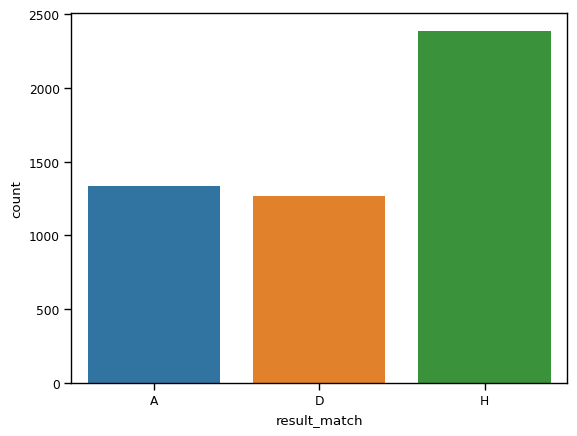

In [37]:
print(f'value counts: \n{df_drop.result_match.value_counts()}')


sns.countplot(x='result_match',data=df_drop)
plt.show()

In [38]:
def preprocess_category_string(category_row):
    if category_row == 'H':
        return 'yes'
    else:
        return 'no'

In [39]:
# change target to binary
df_drop['home_winner'] = df_drop.result_match.apply(lambda x: preprocess_category_string(x))
df_drop['home_winner'].value_counts()

no     2601
yes    2386
Name: home_winner, dtype: int64

In [40]:
def preprocess_if_bet_placed_well(X, colH, colD, colA):
    # print(f'B365H: {X.colH}, colD: {X.B365D}, colA: {X.B365A}, result: {X.result_match} ')
    if (X.get(colH) < X.get(colA)) & (X.get('result_match') == 'H'):
        return True
    elif (X.get(colH) > X.get(colA)) & (X.get('result_match') == 'A'):
        return True
    elif ((X.get(colD) < X.get(colA)) & (X.get(colD) < X.get(colH))) & (X.get('result_match') == 'D'):
        return True
    else:
        return False

def get_result_name(short_name):
    if short_name == 'H':
        return 'home tem win.'
    elif short_name == 'D':
        return 'draw.'
    else:
        return 'away team win.'


def get_bookmaker_type(short_name):
    return [short_name[:-1], short_name[-1]]

In [41]:
def aggregate_bookmarks_bets(X, colH, colD, colA):
    new_df = pd.DataFrame(columns=['bookmaker', 'type', 'good_bet', 'wrong_bet'])
    df_ = X.copy()

    df_['bet_vs_result'] = X[[colH, colD, colA, 'result_match']].apply(lambda x: preprocess_if_bet_placed_well(x, colH, colD, colA), axis=1)

    logger.debug(f"len new col: {df_['bet_vs_result'].value_counts()}")

    df_group = df_.groupby(by=['result_match', 'bet_vs_result'], )['bet_vs_result'].count()
    uniques = df_group.index.get_level_values(0).unique()

    for i in list(uniques):
        df_single = df_group.get(i)
        dict_ = {
            'bookmaker': get_bookmaker_type(colH)[0],
            'type': get_bookmaker_type(i)[1],
            'good_bet': df_single[0],
            'wrong_bet': df_single[1]
        }
        frame = pd.DataFrame(dict_, index=[0])
        new_df = pd.concat([new_df, frame])
    return new_df

In [42]:
df_scoring_bet = pd.DataFrame(columns=['bookmaker', 'type', 'good_bet', 'wrong_bet'])

In [43]:
b365_df = aggregate_bookmarks_bets(df_drop, 'B365H', 'B365D', 'B365A')
bw_df = aggregate_bookmarks_bets(df_drop, 'BWH', 'BWD', 'BWA')
lb_df = aggregate_bookmarks_bets(df_drop, 'LBH', 'LBD', 'LBA')
wh_df = aggregate_bookmarks_bets(df_drop, 'WHH', 'WHD', 'WHA')

In [44]:
bets_bookmark_res = pd.concat([bw_df, lb_df, b365_df, wh_df])
bets_bookmark_res = bets_bookmark_res.set_index(['bookmaker', 'type'])
logger.debug(bets_bookmark_res)

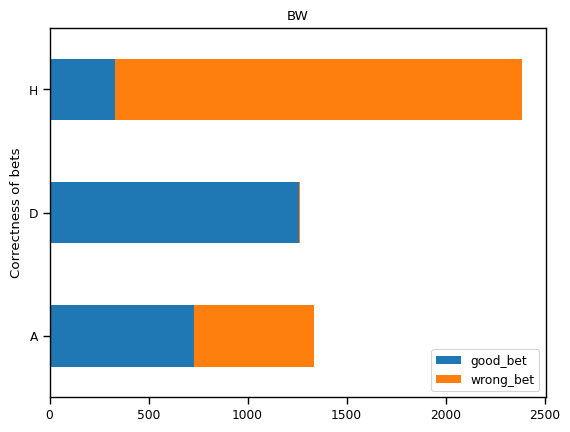

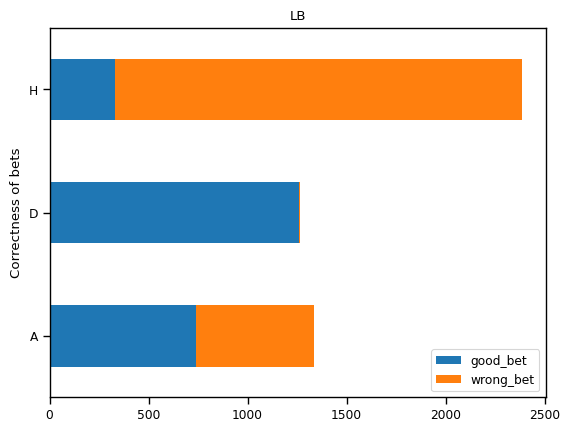

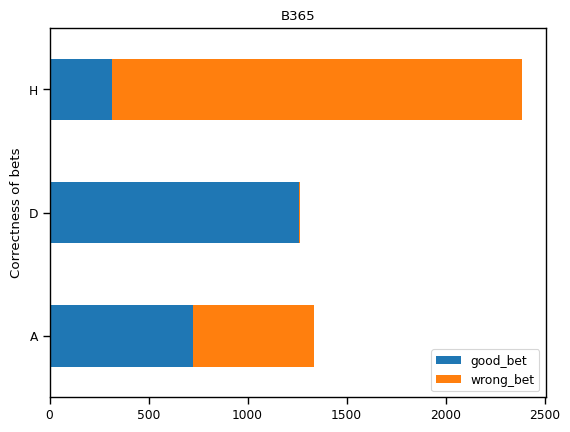

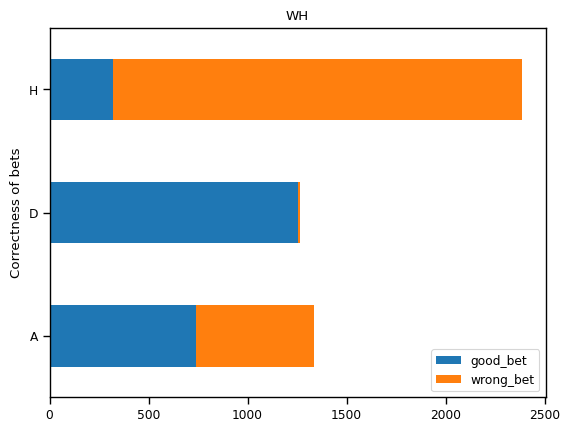

In [45]:
uniques = bets_bookmark_res.index.get_level_values(0).unique()
for i in list(uniques):
    df_single = bets_bookmark_res.loc[i]
    df_single.plot(kind='barh',stacked=True, title=i, xlabel='Correctness of bets')
    plt.show()

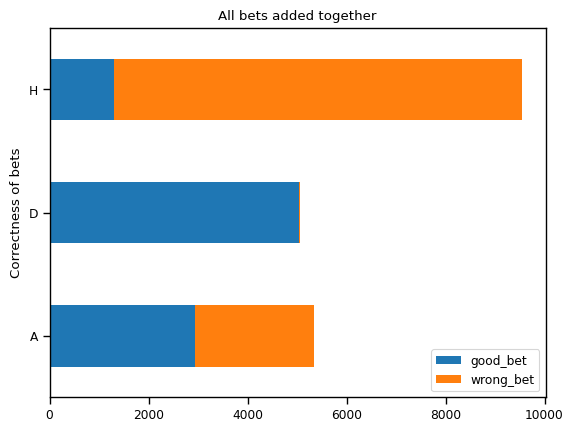

In [46]:
bets_bookmark_sum = bets_bookmark_res.droplevel(0).groupby(['type']).sum().loc[:, ['good_bet', 'wrong_bet']]
bets_bookmark_sum.plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')
plt.show()

In [47]:
streak_df = df_drop[['streak_last_wh', 'streak_last_wa', 'streak_last_lh', 'streak_last_la', 'result_match']]

In [48]:
def check_streak_with_win_probability(X, colH, colA):
    # print(f'colH: {X.get(colH)}\ncolA: {X.get(colA)}\n')
    if ((X.get(colH) > X.get(colA)) & (X.get('result_match') == 'H')) |\
            ((X.get(colH) < X.get(colA)) & (X.get('result_match') == 'A')) |\
            ((X.get(colH) == X.get(colA)) & (X.get('result_match') == 'D')):
        return True
    else:
        return False

def aggregate_streaks(X, colH, colA):
    new_df = pd.DataFrame(columns=[ 'type', 'good_streak', 'wrong_streak'])
    df_ = X.copy()

    df_['streak_vs_result'] = X[[colH, colA, 'result_match']].apply(lambda x: check_streak_with_win_probability(x, colH, colA), axis=1)

    logger.debug(f"len new col: {df_['streak_vs_result'].value_counts()}")

    df_group = df_.groupby(by=['result_match', 'streak_vs_result'], )['streak_vs_result'].count()
    uniques = df_group.index.get_level_values(0).unique()

    for i in list(uniques):
        df_single = df_group.get(i)
        dict_ = {
            'type': i,
            'good_streak': df_single[0],
            'wrong_streak': df_single[1]
        }
        frame = pd.DataFrame(dict_, index=[0])
        new_df = pd.concat([new_df, frame])
    return new_df

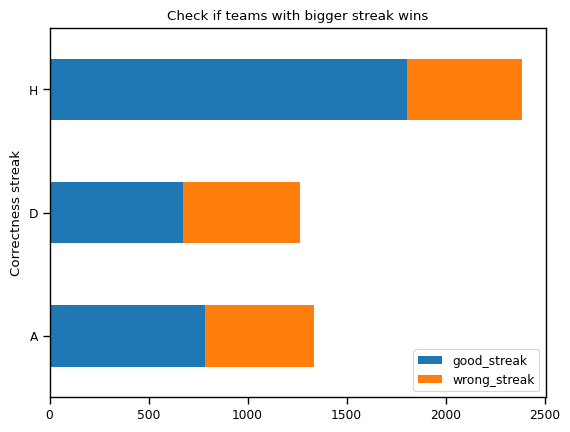

In [49]:
streak_df_agg = aggregate_streaks(df_drop, 'streak_last_wh', 'streak_last_wa')
streak_df_agg.set_index(keys='type', inplace=True)
streak_df_agg.plot(kind='barh',stacked=True, title='Check if teams with bigger streak wins', xlabel='Correctness streak')
plt.show()

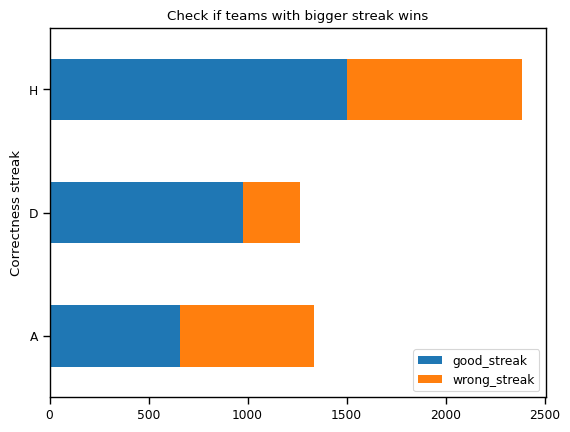

In [50]:
streak_df_agg_a = aggregate_streaks(df_drop, 'streak_last_la', 'streak_last_lh')#%%
streak_df_agg_a.set_index(keys='type', inplace=True)
streak_df_agg_a.plot(kind='barh',stacked=True, title='Check if teams with bigger streak wins', xlabel='Correctness streak')
plt.show()

In [51]:
df_drop['streak_vs_win'] = streak_df[['streak_last_wh', 'streak_last_wa']].apply(lambda x: check_streak_with_win_probability(x, 'streak_last_wh', 'streak_last_wa'), axis=1)
# df_drop['streak_vs_win'].plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')

df_drop['streak_vs_win'].value_counts()

False    4987
Name: streak_vs_win, dtype: int64

In [52]:
df_drop.drop(['streak_vs_win'], axis=1, inplace=True)

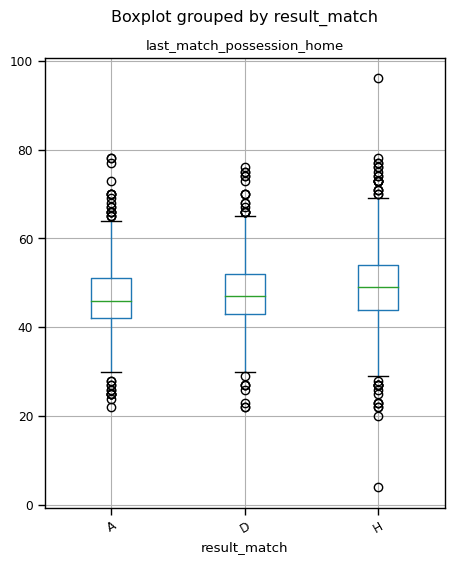

count    4984.000000
mean       48.162921
std         7.644228
min        22.000000
25%        44.000000
50%        48.000000
75%        53.000000
max        78.000000
Name: last_match_possession_home, dtype: float64

In [53]:
df_drop.boxplot('last_match_possession_home', 'result_match', rot=30, figsize=(5, 6))
plt.show()
# probably cols to remove, check feature importance
df_drop['last_match_possession_home'].loc[(df_drop['last_match_possession_home'] < 80) & (df_drop['last_match_possession_home'] > 20)].describe()

In [54]:
df_drop.select_dtypes(exclude=['number']).nunique()

country_name      5
league_name       5
season            4
home_team       128
away_team       128
result_match      3
lm_winner       126
home_winner       2
dtype: int64

In [55]:
categorical_columns = df_drop.select_dtypes(exclude=['number']).columns

In [56]:
from scipy.stats import chi2_contingency
#Testing the relationship
chi_res = chi2_contingency(pd.crosstab(df_drop['home_winner'], df_drop['home_team']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 453.73231140300487, p-value: 2.825872739934144e-38


In [57]:
property_dummies = pd.get_dummies(data = df_drop[['home_team', 'home_winner']], columns = ['home_team'])
property_dummies.columns

Index(['home_winner', 'home_team_1. FC Kaiserslautern', 'home_team_1. FC Köln',
       'home_team_1. FC Nürnberg', 'home_team_1. FSV Mainz 05',
       'home_team_AC Ajaccio', 'home_team_AC Arles-Avignon',
       'home_team_AJ Auxerre', 'home_team_AS Monaco',
       'home_team_AS Nancy-Lorraine',
       ...
       'home_team_VfB Stuttgart', 'home_team_VfL Bochum',
       'home_team_VfL Wolfsburg', 'home_team_Villarreal CF',
       'home_team_West Bromwich Albion', 'home_team_West Ham United',
       'home_team_Wigan Athletic', 'home_team_Wolverhampton Wanderers',
       'home_team_Xerez Club Deportivo', 'home_team_Évian Thonon Gaillard FC'],
      dtype='object', length=129)

In [58]:
#Example
chi_res = chi2_contingency(pd.crosstab(property_dummies['home_winner'], property_dummies['home_team_West Bromwich Albion']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 1.559582723823823, p-value: 0.21172632797970442


In [59]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(df_drop['result_match'], df_drop[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check]).T
res.columns = ['Column', 'Hypothesis']
print(res)

         Column                      Hypothesis
0  country_name          Reject Null Hypothesis
1   league_name          Reject Null Hypothesis
2        season  Fail to Reject Null Hypothesis
3     home_team          Reject Null Hypothesis
4     away_team          Reject Null Hypothesis
5  result_match          Reject Null Hypothesis
6     lm_winner  Fail to Reject Null Hypothesis
7   home_winner          Reject Null Hypothesis


In [60]:
check = {}
for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(df_drop[i])
    bon_p_value = 0.05/df_drop[i].nunique()
    for series in dummies:
        if chi2_contingency(pd.crosstab(df_drop['result_match'], dummies[series]))[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi_ph = pd.DataFrame(data = [check.keys(), check.values()]).T
res_chi_ph.columns = ['Pair', 'Hypothesis']
res_chi_ph

,Pair,Hypothesis
0,country_name-England,Fail to Reject Null Hypothesis
1,country_name-France,Reject Null Hypothesis
2,country_name-Germany,Reject Null Hypothesis
3,country_name-Italy,Fail to Reject Null Hypothesis
4,country_name-Spain,Fail to Reject Null Hypothesis
...,...,...
266,result_match-A,Reject Null Hypothesis
267,result_match-D,Reject Null Hypothesis
268,result_match-H,Reject Null Hypothesis
269,home_winner-no,Reject Null Hypothesis


In [61]:
res_chi_ph.Hypothesis.value_counts()

Fail to Reject Null Hypothesis    252
Reject Null Hypothesis             19
Name: Hypothesis, dtype: int64

In [62]:
from sklearn.model_selection import train_test_split

data_log = pd.get_dummies(data=df_drop, columns = df_drop.select_dtypes(exclude = 'number').drop('result_match', axis =1).columns, drop_first =True)
data_log['result_match'] = data_log['result_match'].apply(lambda x: 0 if x == 'H' else (1 if x == 'D' else 2))

X_train, X_test, y_train, y_test = train_test_split(data_log.drop('result_match', axis =1), data_log['result_match'], test_size = 0.2, random_state=333)

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [63]:
df_drop.select_dtypes(include='number')

,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,last_match_possession_home,days_since_lma,days_since_lmh,avg_points_l5m_h,avg_points_l5m_a,points_home,points_away,date_year,date_month,date_day
0,1,1.57,3.80,6.00,1.55,3.70,5.45,1.53,3.50,5.50,...,60,10,10,1.528571,1.857143,0,0,2008,8,15
1,1,1.20,6.50,15.00,1.22,5.50,10.00,1.20,5.00,11.00,...,54,9,9,1.435294,1.082353,0,0,2008,8,16
2,1,5.50,3.60,1.67,5.00,3.35,1.67,4.50,3.30,1.67,...,48,9,9,1.100000,1.635294,0,0,2008,8,16
3,1,1.91,3.40,4.20,1.90,3.20,3.80,1.80,3.20,4.00,...,48,9,9,1.175000,1.312500,0,0,2008,8,16
4,1,2.00,3.30,4.00,1.85,3.25,4.00,1.80,3.20,4.00,...,50,9,9,1.223529,1.129412,0,0,2008,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,13,1.44,4.00,8.00,1.53,3.75,6.75,1.44,3.75,6.00,...,40,8,8,0.800000,0.000000,2,0,2011,11,6
4996,13,1.44,4.00,8.00,1.43,4.30,7.50,1.40,3.75,7.00,...,40,7,8,1.400000,1.800000,1,4,2011,11,6
4997,13,2.30,3.10,3.25,2.30,3.00,3.30,2.25,2.88,3.00,...,40,8,8,1.800000,1.200000,1,3,2011,11,6
4998,13,1.80,3.25,5.00,1.75,3.30,5.00,1.67,3.30,4.50,...,40,7,7,1.200000,1.400000,4,1,2011,11,6


c:\users\kamil\documents\eu_soccer_ml\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


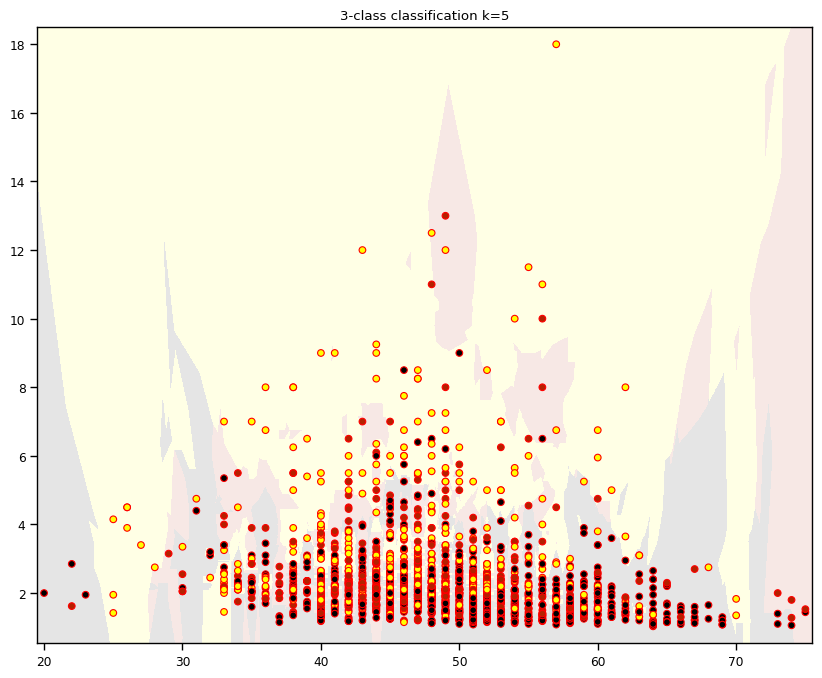

In [69]:
data = X_train.select_dtypes(include=['number']).loc[:100, ['last_match_possession_home', 'BWH']]

def plot_decision_boundries(X, y, n_neighbors=1):

    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(X, y)

    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(mesh)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap='gnuplot', alpha=0.1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='gnuplot', edgecolors='r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'3-class classification k={n_neighbors}')
    plt.show()

plot_decision_boundries(data, y_train.loc[:100], n_neighbors=5)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.4759519038076152
              precision    recall  f1-score   support

           0       0.54      0.73      0.62       484
           1       0.29      0.24      0.26       243
           2       0.44      0.23      0.31       271

    accuracy                           0.48       998
   macro avg       0.42      0.40      0.40       998
weighted avg       0.45      0.48      0.45       998



In [63]:
# _ = sns.pairplot(df_drop, vars=df_drop.select_dtypes(include=['number']), hue='result_match')
# plt.savefig('plot/pair_plot.png')

In [54]:
def categorical_filter(df, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories
    """
    list_of_features = []
    for i in df.columns:
        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if df[i].nunique() <= high_inclusive and df[i].nunique() > low_exclusive:
                list_of_features.append(i)
    return list_of_features

In [55]:
category_1_cols = categorical_filter(df_drop, 1, 1 )
print('# of Constant Variables = ',len(category_1_cols))

# of Constant Variables =  0


In [56]:
category_2_cols = categorical_filter(df_drop, 1, 2)
print('# of Binary Varialbes = ',len(category_2_cols))

# of Binary Varialbes =  1


In [57]:
category_15_cols = categorical_filter(df_drop, 2, 15)
print('# of Variables less than or equal to 15 categories = ',len(category_15_cols))

# of Variables less than or equal to 15 categories =  10


In [58]:
remainder_cols = categorical_filter(df_drop, 15, len(df_drop))
print('# of Continuous Variables (with more than 15 categories) = ',len(remainder_cols))

# of Continuous Variables (with more than 15 categories) =  31


In [59]:
df_drop[category_2_cols].value_counts()

home_winner
no             2601
yes            2386
dtype: int64

In [80]:
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

In [81]:
train_df_categorical = df_drop[category_15_cols]

le=LabelEncoder()

# create a dataframe to store label encoded values
train_df_categorical_le = train_df_categorical.copy()

for i in train_df_categorical.columns:
    train_df_categorical_le[i] = le.fit_transform(train_df_categorical[i]).copy()

In [82]:
train_df_categorical_le

,country_name,league_name,season,result_match,lm_goals_away,lm_goals_home,streak_last_wh,streak_last_wa,date_year,date_month
0,2,2,0,1,2,2,0,0,0,5
1,0,0,0,2,1,2,0,0,0,5
2,0,0,0,0,2,1,0,0,0,5
3,0,0,0,2,1,1,0,0,0,5
4,0,0,0,0,1,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...
4995,1,1,3,2,0,1,0,0,3,8
4996,1,1,3,2,1,3,1,0,3,8
4997,1,1,3,2,3,0,0,1,3,8
4998,1,1,3,1,0,0,0,0,3,8


In [63]:
df.result_match.value_counts(normalize=True)

H    0.478574
A    0.267922
D    0.253504
Name: result_match, dtype: float64

In [ ]:
df_num = df_drop.select_dtypes(include='number')
df_cat = df_drop.select_dtypes(exclude='number')

In [ ]:
le = preprocessing.LabelEncoder()
X = df_drop
y = le.fit_transform(X.home_winner)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

In [ ]:
X = X.drop(['result_match', 'homer_winner'])

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
